In [32]:
import pandas as pd
bel_data = pd.read_csv("/Users/miraslavats/Library/CloudStorage/GoogleDrive-miraslava@uni.minerva.edu/My Drive/Capstone/translated_1350_entries.csv")

In [39]:
bel_data.head()

,Index,Title,Links,Date,Transcriptions,translated_Transcriptions,Year,Month
0,0,1 сентября _ Готовность к учебному году _ Ремо...,https://rutube.ru/video/6ecd6c4bc6753e4ba8d8f3...,2024-08-29,"Кто хотела украсть 1 сентября? Представьте, э...","Who wanted to steal September 1st? Imagine, th...",2024.0,August
1,1,Белорус Игорь Бокий завоевал первую медаль на ...,https://rutube.ru/video/12b0d54c8ebdffe9226b82...,2024-08-29,Победные новости только что пришли из Парижа....,Winning news has just come from Paris. The mai...,2024.0,August
2,6,В Польшу с украинской стороны залетел беспилот...,https://rutube.ru/video/b364060bfc71d6bc19a372...,2024-08-29,"Польше находятся в состоянии гибридной войны,...","Poland is in a state of hybrid war, this was o...",2024.0,August
3,10,Беларусь изучают как будущий театр военных дей...,https://rutube.ru/video/cfa70cd9af6b25beddef83...,2024-08-28,"Вопереди спозиция, это Гагарин поехали. Балти...","Ahead lies the army exercise, it’s time for Ga...",2024.0,August
4,20,Жители Польши в шоке! Представители партии PIS...,https://rutube.ru/video/877d4f511b1cc4da1417ea...,2024-08-25,ВОЗГЛАЯ МУЗЫКА Вот уже несколько дней прибыва...,"MUSIC OF THE CALL\n\nFor several days now, I h...",2024.0,August


In [35]:
bel_data['Date Published'] = pd.to_datetime(bel_data['Date Published'])
bel_data['Year'] = bel_data['Date Published'].dt.year
bel_data['Month'] = bel_data['Date Published'].dt.month_name()

bel_data = bel_data.rename(columns={'Date Published': 'Date'})
bel_data['Date'] = pd.to_datetime(bel_data['Date']).dt.date

In [43]:
# Grouping the data by Year and Month, combining texts into lists
grouped_data = bel_data.groupby(['Year', 'Month']).agg({
    'translated_Transcriptions': list,  # Combine texts into lists
    'Date': 'min'  # Keep the earliest date in each group
}).reset_index()

### 1. Splitting the news' transcripts into smaller chunks

In [44]:
# Splitting the news transcripts into smaller chunks for processing
def split_text_into_chunks(text, max_length=500):
    words = text.split()
    return [' '.join(words[i:i + max_length]) for i in range(0, len(words), max_length)]

grouped_data['Chunks'] = grouped_data['translated_Transcriptions'].apply(
    lambda texts: [chunk for text in texts for chunk in split_text_into_chunks(text)]
)

In [45]:
grouped_data.head()

,Year,Month,translated_Transcriptions,Date,Chunks
0,2022.0,August,[MUSICAL INTRO Belarus celebrates Independence...,2022-08-31,[MUSICAL INTRO Belarus celebrates Independence...
1,2022.0,March,"[Hello everyone, I am Maria Petrashka from the...",2022-03-06,"[Hello everyone, I am Maria Petrashka from the..."
2,2023.0,April,[DYNAMIC MUSIC Unreliable allies of the Russia...,2023-04-02,[DYNAMIC MUSIC Unreliable allies of the Russia...
3,2023.0,August,[And now about our interests in the Russian Ar...,2023-08-01,[And now about our interests in the Russian Ar...
4,2023.0,December,"[In 2023, we saw a year of peace and creation,...",2023-12-01,"[In 2023, we saw a year of peace and creation,..."


In [47]:
# Splitting the text chunks in the "Chunks" column into separate rows
exploded_data = grouped_data.explode('Chunks', ignore_index=True)
# Dropping unnecessary columns for BERTopic
exploded_data_for_modeling = exploded_data[['Date', 'Chunks']].dropna()

In [55]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer

# Custom stopwords
custom_stopwords = set(ENGLISH_STOP_WORDS).union({"the", "and", "of", "to", "in", 
                                                  "is", "we", "this", "that", "for", 
                                                  "one", "two", "just", "its", "yes", 
                                                  "no", "it"})
# Converting to list for the vectorizer
stopwords_list = ["the", "and", "of", "to", "in", "is", "we", "this", "that", "for", 
                  "one", "two", "just", "its", "yes", "no", "it"]

# Preprocess text data to remove stopwords
def preprocess_text(text):
    words = text.split()
    return " ".join(word for word in words if word.lower() not in custom_stopwords)

# Apply preprocessing to the dataset
exploded_data_for_modeling['Processed_Chunks'] = exploded_data_for_modeling['Chunks'].apply(preprocess_text)
vectorizer_model = CountVectorizer(stop_words=stopwords_list)

# Fit BERTopic on the preprocessed text
model = BERTopic(vectorizer_model=vectorizer_model)
topics, probs = model.fit_transform(exploded_data_for_modeling['Processed_Chunks'])

In [56]:
exploded_data_for_modeling

,Date,Chunks,Processed_Chunks
0,2022-08-31,MUSICAL INTRO Belarus celebrates Independence ...,MUSICAL INTRO Belarus celebrates Independence ...
1,2022-08-31,about their desires. They had a set goal of de...,desires. set goal destroying local Belarusian ...
2,2022-08-31,hunt for her and her family. This is what a wo...,"hunt family. woman, seen life, says Nazism. un..."
3,2022-08-31,my results from the criminal investigation est...,results criminal investigation established 198...
4,2022-08-31,War. The memory of the Great Patriotic War is ...,War. memory Great Patriotic War safeguard Bela...
...,...,...,...
4949,2024-09-12,discussing fewer problematic questions. Whethe...,discussing fewer problematic questions. likes ...
4950,2024-09-12,"Belarus, which should, in fact, create common ...","Belarus, should, fact, create common condition..."
4951,2024-09-12,Threats to the union state and beyond were dis...,Threats union state discussed today response A...
4952,2024-09-12,he had an arsenal of combat grenades. There ar...,arsenal combat grenades. episodes development ...


## Topic names and descriptions with OpenAI

In [59]:
# Getting the top words for all topics
all_topics = model.get_topics()
topic_words = {topic_id: [word for word, _ in words] for topic_id, words in all_topics.items()}

In [60]:
# Creating pseudo-documents from the top words
pseudo_documents = {topic_id: " ".join(words) for topic_id, words in topic_words.items()}

In [61]:
import openai
openai.api_key = ""

# Function to generate topic name and description
def generate_topic_name_description(topic_words):
    prompt = f"""The following words represent a topic: {', '.join(topic_words)}. 
    Based on these words, provide:
    1. A concise topic name (3-5 words).
    2. A short description (1-2 sentences) explaining the topic.

    Output:
    - Topic Name: 
    - Description:"""
    
    response = openai.chat.completions.create(
        model="gpt-4",  # or "gpt-3.5-turbo" if that's preferred
        messages=[{"role": "user", "content": prompt}],
        temperature=0.7
    )
    
    return response.choices[0].message.content.strip()

In [63]:
# Generating topic names and descriptions
topic_names_descriptions = {}
for topic_id, words in topic_words.items():
    output = generate_topic_name_description(words)
    topic_names_descriptions[topic_id] = output

In [58]:
topic_names_descriptions

## Connecting the topics to ids

In [139]:
# Matching the topic ids and topic names
topic_names = {topic_id: desc.split("\n")[0].replace("- Topic Name: ", "").strip() 
               for topic_id, desc in topic_names_descriptions.items()}

In [140]:
# Adding topic IDs and names to the dataset
exploded_data_for_modeling['Assigned_Topic_ID'] = topics
exploded_data_for_modeling['Assigned_Topic_Name'] = exploded_data_for_modeling['Assigned_Topic_ID'].map(topic_names)

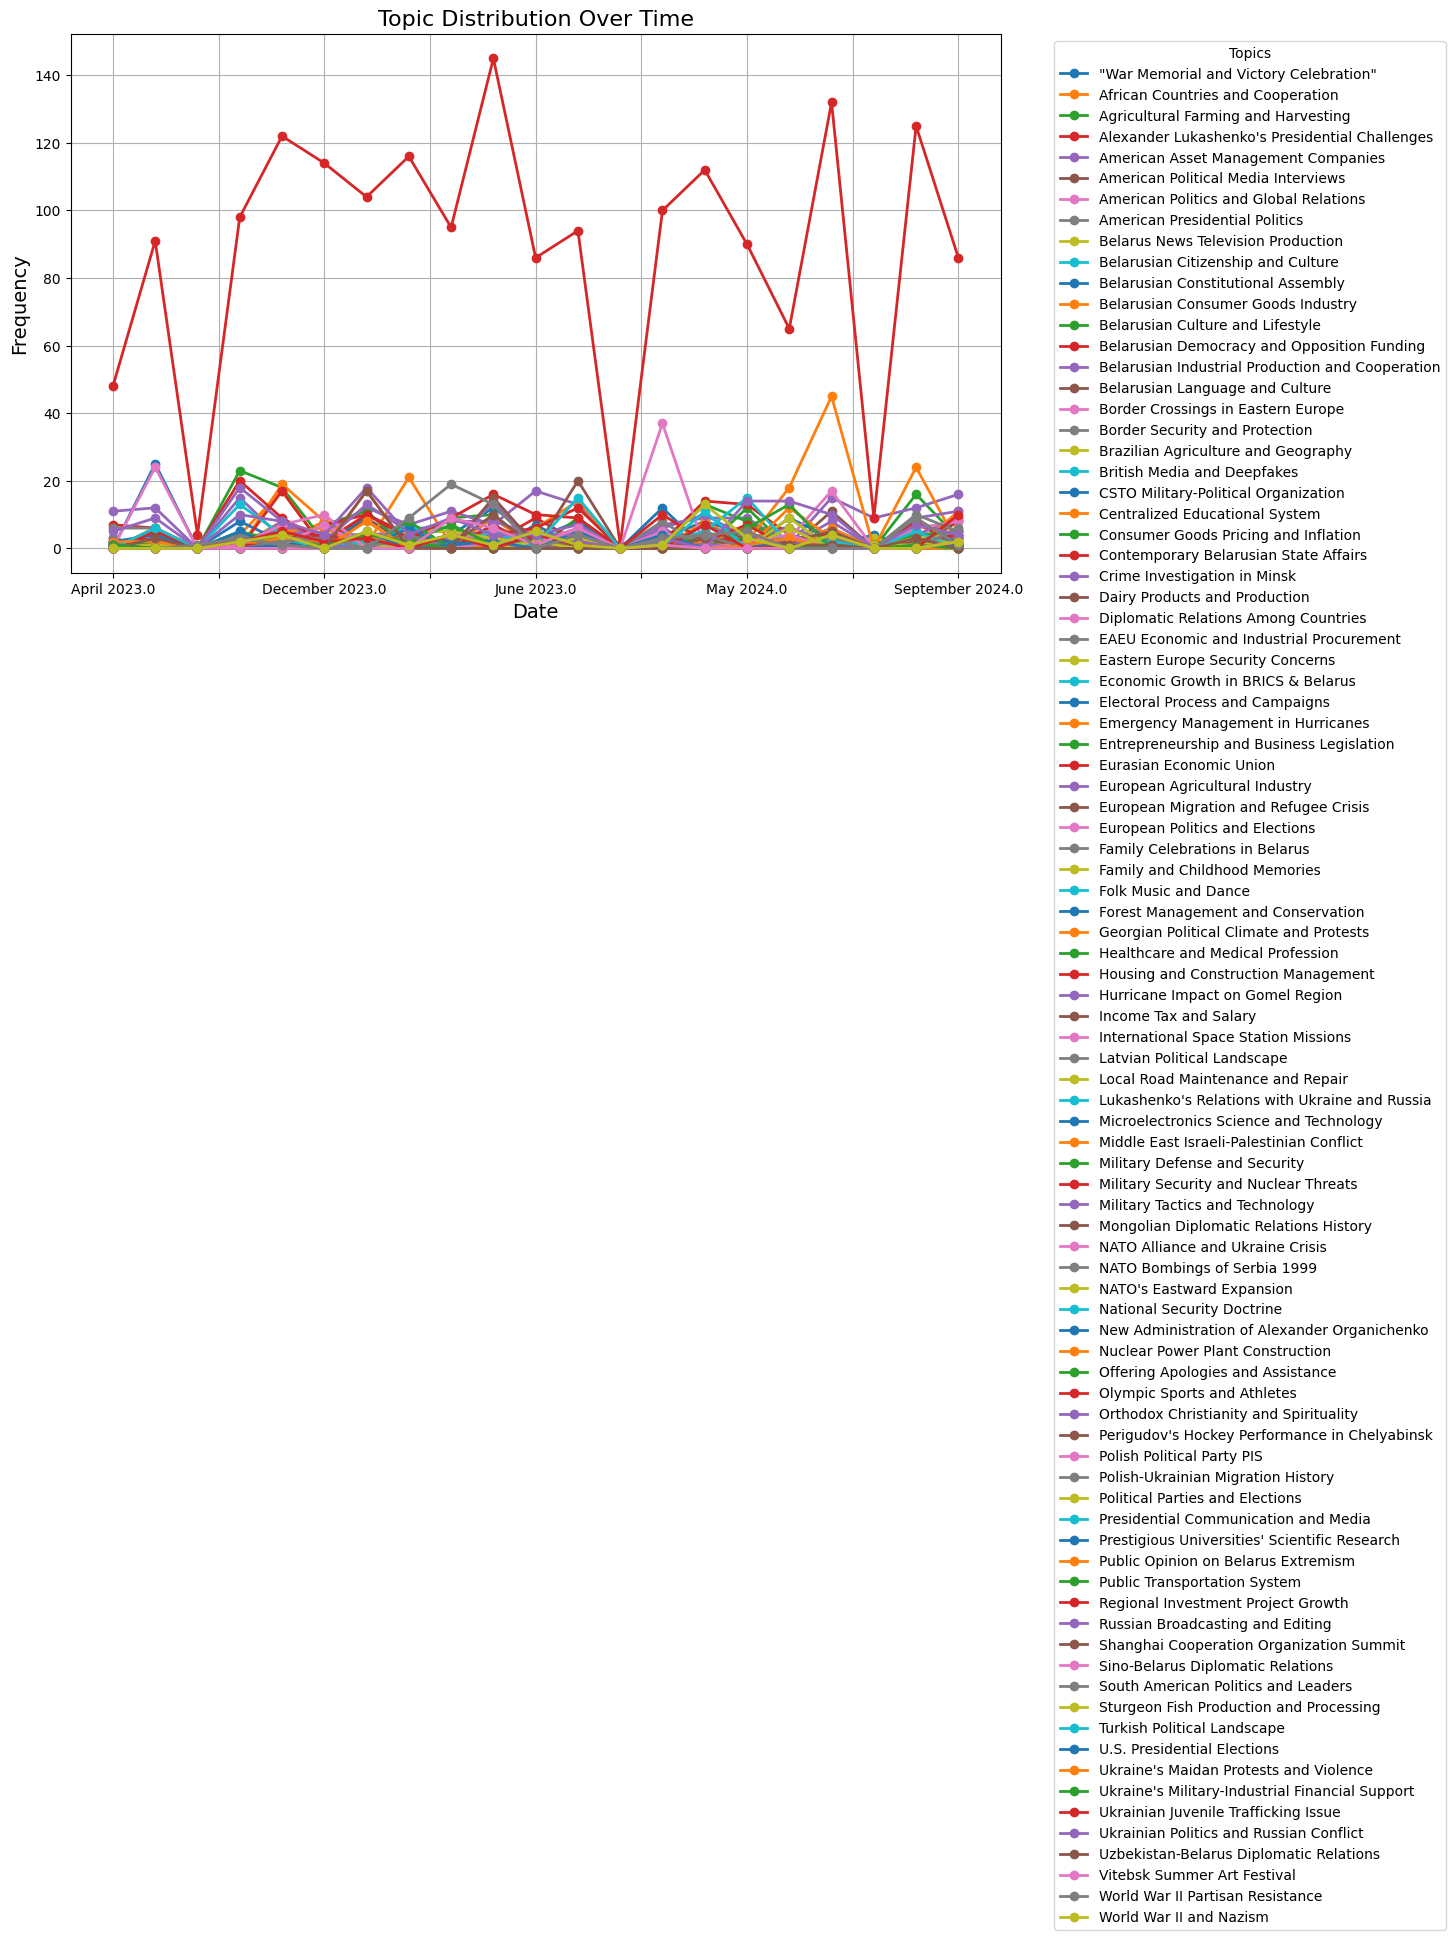

In [143]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by date and topic name to calculate frequency
topic_frequencies = (
    exploded_data_for_modeling
    .groupby(['Date', 'Assigned_Topic_Name'])
    .size()
    .reset_index(name='Frequency')
)

pivoted_data = topic_frequencies.pivot(index='Date', columns='Assigned_Topic_Name', values='Frequency').fillna(0)
pivoted_data.plot(kind='line', figsize=(12, 7), marker='o', linewidth=2)

plt.title('Topic Distribution Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(title='Topics', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True)
plt.tight_layout()

plt.show()

## Larger groups

In [116]:
topic_groups = {
    "Belarusian opposition": [22, 35],
    "Belarusian Internal Politics": [-1, 0, 4, 8, 10, 11, 12, 16, 37, 39, 44, 45, 46, 56, 63, 66, 70, 72, 76, 77, 87],
    "Belarusian Culture and Development": [7, 13, 20, 28, 32, 38, 40, 41, 43, 54, 55, 59, 60, 65, 67, 71],
    "US-Related Politics": [21, 34, 48, 49, 52, 64, 78, 80, 85],
    "World War II-Related Topics": [9, 15, 19],
    "Sports": [2, 69],
    "Belarusian Regional and International Cooperation": [6, 23, 25, 29, 31, 33, 30, 50, 61, 73, 81, 82],
    "Russian War on Ukraine": [1, 3, 24, 27, 53, 74, 83],
    "Global Politics": [5, 42, 51, 75, 79],
    "European Politics and Migration": [14, 17, 26, 36, 47, 57, 58, 62, 68, 84, 86],
}

In [117]:
def assign_group(topic_id):
    for group, ids in topic_groups.items():
        if topic_id in ids:
            return group
    return "Other"

exploded_data_for_modeling["Group"] = exploded_data_for_modeling["Assigned_Topic_ID"].apply(assign_group)

In [71]:
exploded_data_for_modeling = exploded_data_for_modeling[exploded_data_for_modeling["Group"] != "Other"]

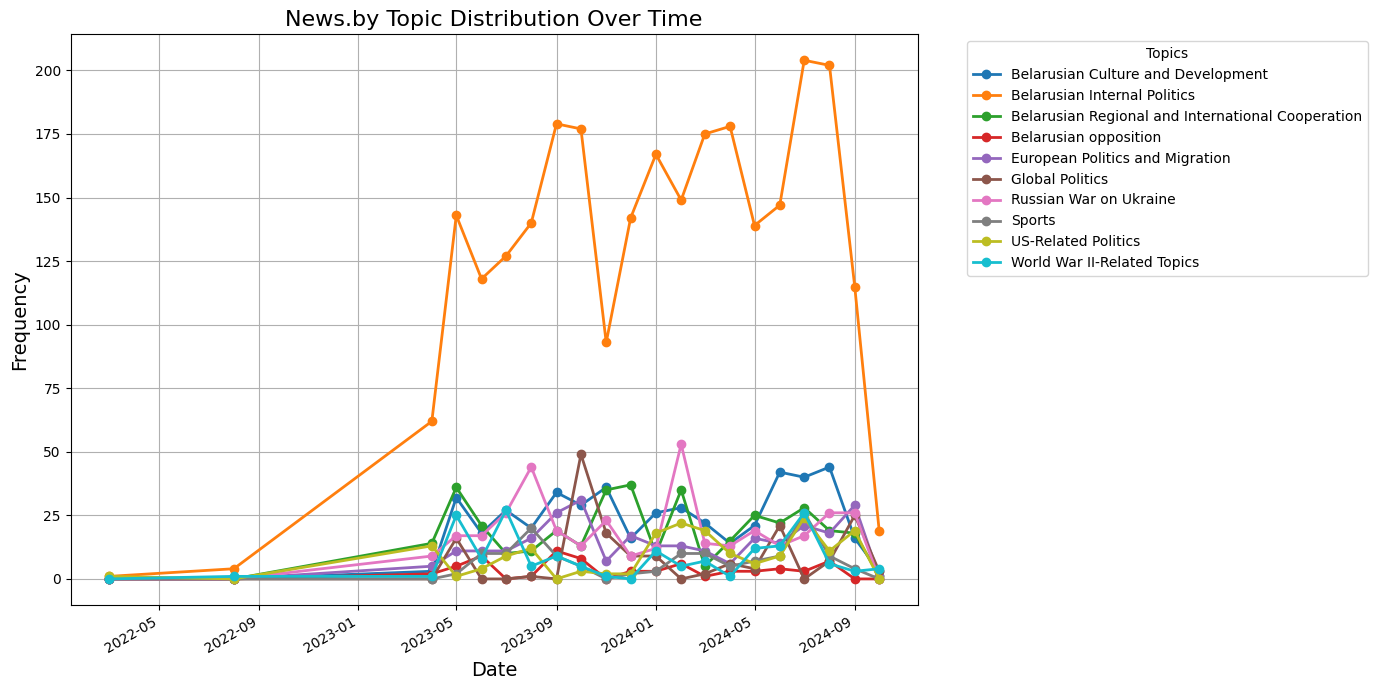

In [76]:
# Grouping by date and topic name to calculate frequency
topic_frequencies = (
    exploded_data_for_modeling
    .groupby(['Date', 'Group'])
    .size()
    .reset_index(name='Frequency')
)

pivoted_data = topic_frequencies.pivot(index='Date', columns='Group', values='Frequency').fillna(0)
pivoted_data.plot(kind='line', figsize=(14, 7), marker='o', linewidth=2)

plt.title('News.by Topic Distribution Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(title='Topics', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

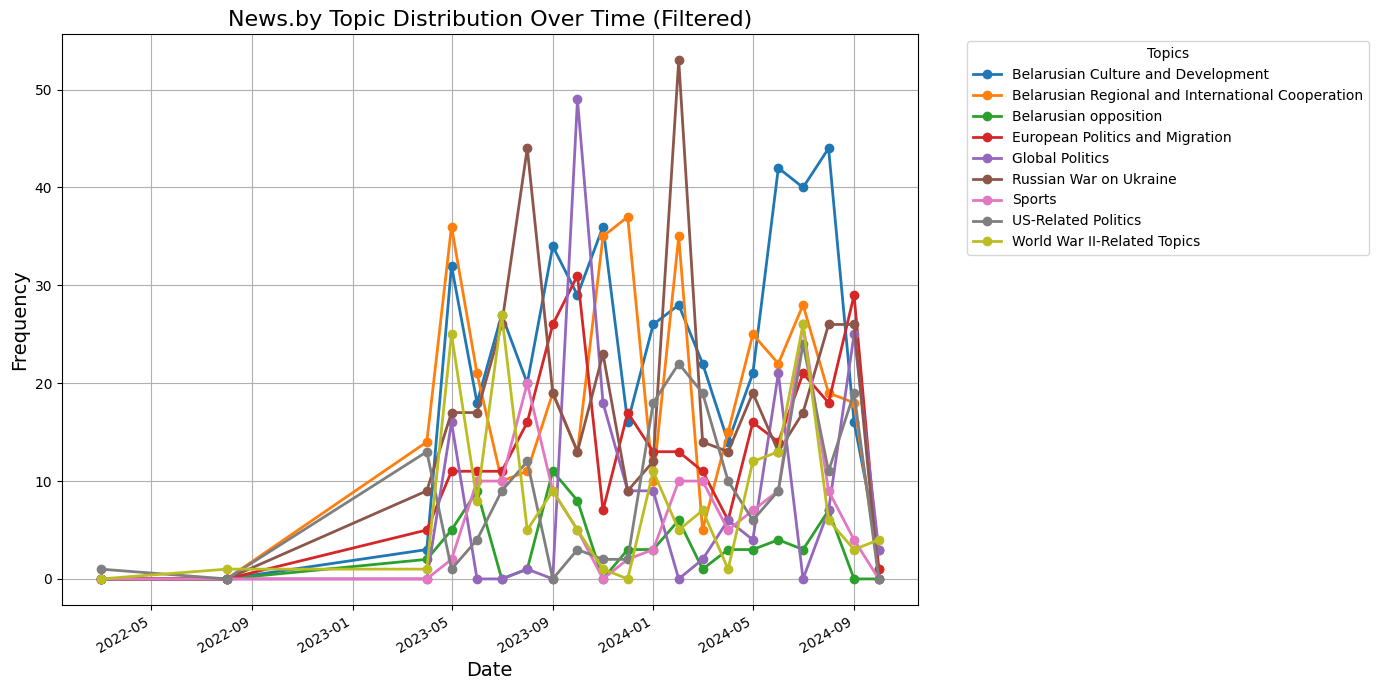

In [77]:
# Plotting the topics distribution without "Belarusian Internal Politics" group to get a closer look
filtered_data = topic_frequencies[topic_frequencies['Group'] != "Belarusian Internal Politics"]
pivoted_data_filtered = filtered_data.pivot(index='Date', columns='Group', values='Frequency').fillna(0)
pivoted_data_filtered = pivoted_data_filtered.loc[(pivoted_data_filtered.sum(axis=1) > 0)]
pivoted_data_filtered.plot(kind='line', figsize=(14, 7), marker='o', linewidth=2)

plt.title('News.by Topic Distribution Over Time (Filtered)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(title='Topics', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

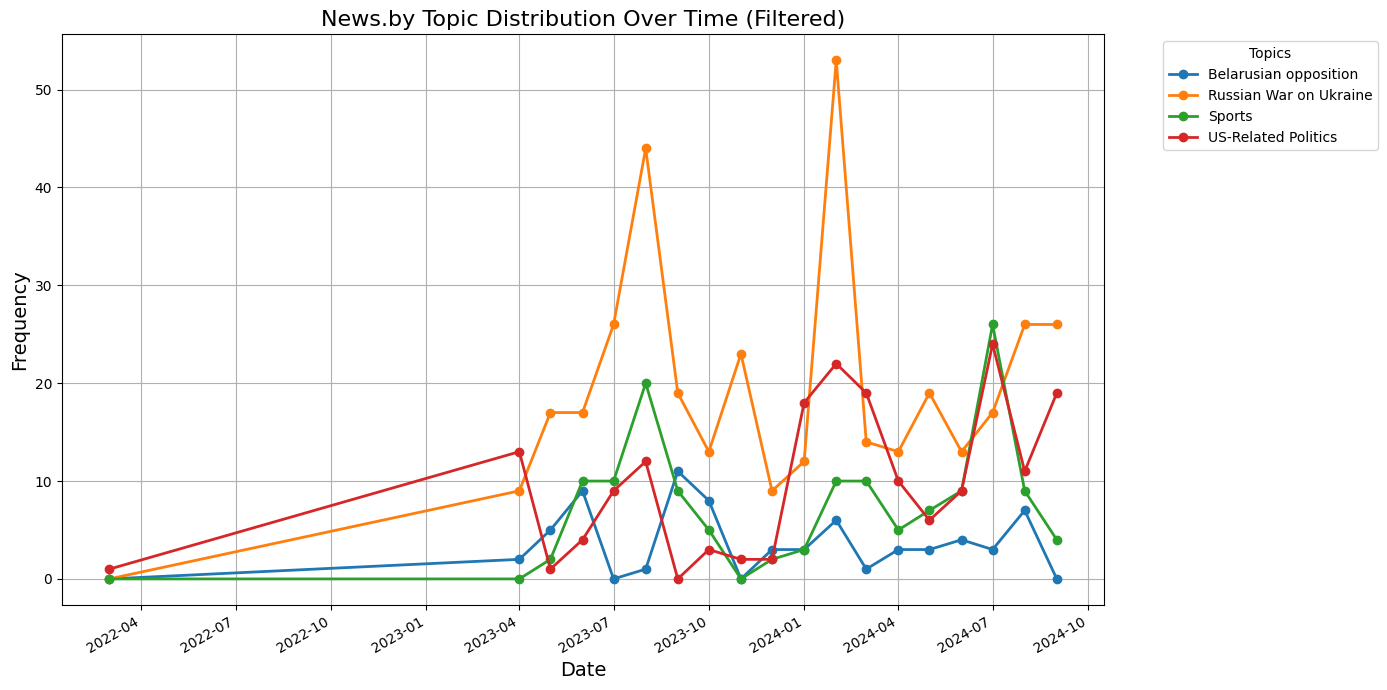

In [80]:
# Plotting the topics distribution without "Belarusian Internal Politics" group to get a closer look
filtered_data = topic_frequencies[topic_frequencies['Group'].isin(["Russian War on Ukraine", "US-Related Politics", "Belarusian opposition", "Sports"])]
pivoted_data_filtered = filtered_data.pivot(index='Date', columns='Group', values='Frequency').fillna(0)
pivoted_data_filtered = pivoted_data_filtered.loc[(pivoted_data_filtered.sum(axis=1) > 0)]
pivoted_data_filtered.plot(kind='line', figsize=(14, 7), marker='o', linewidth=2)

plt.title('News.by Topic Distribution Over Time (Filtered)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(title='Topics', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

## Sentiment Analysis

In [7]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig
import pandas as pd
import numpy as np
from scipy.special import softmax
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [291]:
MODEL = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# Function to calculate sentiment scores for a single text
def get_sentiment_scores(text):
    try:
        encoded_input = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
        output = model(**encoded_input)
        scores = softmax(output[0][0].detach().numpy())
        return {config.id2label[i]: scores[i] for i in range(len(scores))}
    except Exception as e:
        print(f"Error processing text: {text[:50]}... - {e}")
        return {"positive": None, "neutral": None, "negative": None}

tqdm.pandas()
exploded_data_for_modeling['Sentiment_Scores'] = exploded_data_for_modeling['Processed_Chunks'].progress_apply(get_sentiment_scores)

# Extracting scores into separate columns
exploded_data_for_modeling['Positive_Score'] = exploded_data_for_modeling['Sentiment_Scores'].apply(lambda x: x.get('positive'))
exploded_data_for_modeling['Neutral_Score'] = exploded_data_for_modeling['Sentiment_Scores'].apply(lambda x: x.get('neutral'))
exploded_data_for_modeling['Negative_Score'] = exploded_data_for_modeling['Sentiment_Scores'].apply(lambda x: x.get('negative'))
exploded_data_for_modeling.drop(columns=['Sentiment_Scores'], inplace=True)

print(exploded_data_for_modeling.head())

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|███████████████████████████████████████| 4908/4908 [10:46<00:00,  7.59it/s]


            Date                                             Chunks  \
0  August 2022.0  MUSICAL INTRO Belarus celebrates Independence ...   
1  August 2022.0  about their desires. They had a set goal of de...   
2  August 2022.0  hunt for her and her family. This is what a wo...   
3  August 2022.0  my results from the criminal investigation est...   
4  August 2022.0  War. The memory of the Great Patriotic War is ...   

                                    Processed_Chunks  Assigned_Topic_ID  \
0  MUSICAL INTRO Belarus celebrates Independence ...                 -1   
1  desires. set goal destroying local Belarusian ...                 -1   
2  hunt family. woman, seen life, says Nazism. un...                 -1   
3  results criminal investigation established 198...                  9   
4  War. memory Great Patriotic War safeguard Bela...                 -1   

                     Assigned_Topic_Name                         Group  \
0  Contemporary Belarusian State Affairs  Belaru

In [280]:
exploded_data_for_modeling['Final_Sentiment'] = exploded_data_for_modeling[['Positive_Score', 'Neutral_Score', 'Negative_Score']].idxmax(axis=1)
exploded_data_for_modeling['Final_Sentiment_Score'] = exploded_data_for_modeling[['Positive_Score', 'Neutral_Score', 'Negative_Score']].max(axis=1)

In [293]:
exploded_data_for_modeling['Positive_Score'] = exploded_data_for_modeling.apply(lambda x: x['Final_Sentiment_Score'] if x['Final_Sentiment'] == 'Positive_Score' else 0, axis=1)
exploded_data_for_modeling['Neutral_Score'] = exploded_data_for_modeling.apply(lambda x: x['Final_Sentiment_Score'] if x['Final_Sentiment'] == 'Neutral_Score' else 0, axis=1)
exploded_data_for_modeling['Negative_Score'] = exploded_data_for_modeling.apply(lambda x: x['Final_Sentiment_Score'] if x['Final_Sentiment'] == 'Negative_Score' else 0, axis=1)

In [118]:
exploded_data_for_modeling.to_csv('/Users/miraslavats/Library/CloudStorage/GoogleDrive-miraslava@uni.minerva.edu/My Drive/Capstone/bel_sentiment_emotion/sentiment_dataset.csv')

In [114]:
date_mapping = {
    "April 2023.0": "2023-04-01",
    "April 2024.0": "2024-04-01",
    "September 2023.0": "2023-09-01",
    "October 2023.0": "2023-10-01",
    "October 2024.0": "2024-10-01",
    "November 2023.0": "2023-11-01",
    "May 2024.0": "2024-05-01",
    "May 2023.0": "2023-05-01",
    "March 2024.0": "2024-03-01",
    "March 2022.0": "2022-03-01",
    "June 2024.0": "2024-06-01",
    "June 2023.0": "2023-06-01",
    "July 2024.0": "2024-07-01",
    "July 2023.0": "2023-07-01",
    "January 2024.0": "2024-01-01",
    "February 2024.0": "2024-02-01",
    "December 2023.0": "2023-12-01",
    "August 2024.0": "2024-08-01",
    "August 2023.0": "2023-08-01",
    "August 2022.0": "2022-08-01",
    "September 2024.0": "2024-09-01"
}
# Map the dates using the dictionary
exploded_data_for_modeling['Date'] = exploded_data_for_modeling['Date'].map(date_mapping)
exploded_data_for_modeling['Date'] = pd.to_datetime(exploded_data_for_modeling['Date'])

In [3]:
# Group by topics and time
grouped_sentiment = exploded_data_for_modeling.groupby(['Group', 'Date'])[['Positive_Score', 'Neutral_Score', 'Negative_Score']].mean().reset_index()

In [86]:
exploded_data_for_modeling["Date"] = pd.to_datetime(exploded_data_for_modeling["Date"])

# Filter for rows where 'Date' is in July 2024
july_2024_data = exploded_data_for_modeling[
    (exploded_data_for_modeling["Date"].dt.year == 2024) &
    (exploded_data_for_modeling["Date"].dt.month == 7)
]

# Display the relevant "Chunks"
print(july_2024_data["Chunks"].iloc[83])

of one of the units with several policemen. Many of these names turned out to be known, serving under prominent names of Vladimir. Upon the first check, we began to find parallels with Red Army soldiers who fought and were conscripted in '43-44. They fought until victory. Most likely, many fighters from the battalion remained on captured territories, and with the liberation of Belarus, they were incorporated into the Red Army and continued the fight already in the Red part. Some policemen stayed to heal their wounds in villages. Then they joined partisan detachments. Some were captured. Before the breakthrough, the leadership received orders to change clothes into civilian attire. This saved many lives. Some managed to escape and continue the fight against the occupiers. One of those who has been restoring the memory of the battalion for many years is journalist Olga Kasterka from the newspaper "On Guard". Much of what she learned about the fate of the legendary battalion came from the

In [4]:
grouped_sentiment['Total_Score'] = grouped_sentiment[['Positive_Score', 'Neutral_Score', 'Negative_Score']].sum(axis=1)
grouped_sentiment['Positive_Proportion'] = grouped_sentiment['Positive_Score'] / grouped_sentiment['Total_Score']
grouped_sentiment['Neutral_Proportion'] = grouped_sentiment['Neutral_Score'] / grouped_sentiment['Total_Score']
grouped_sentiment['Negative_Proportion'] = grouped_sentiment['Negative_Score'] / grouped_sentiment['Total_Score']

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


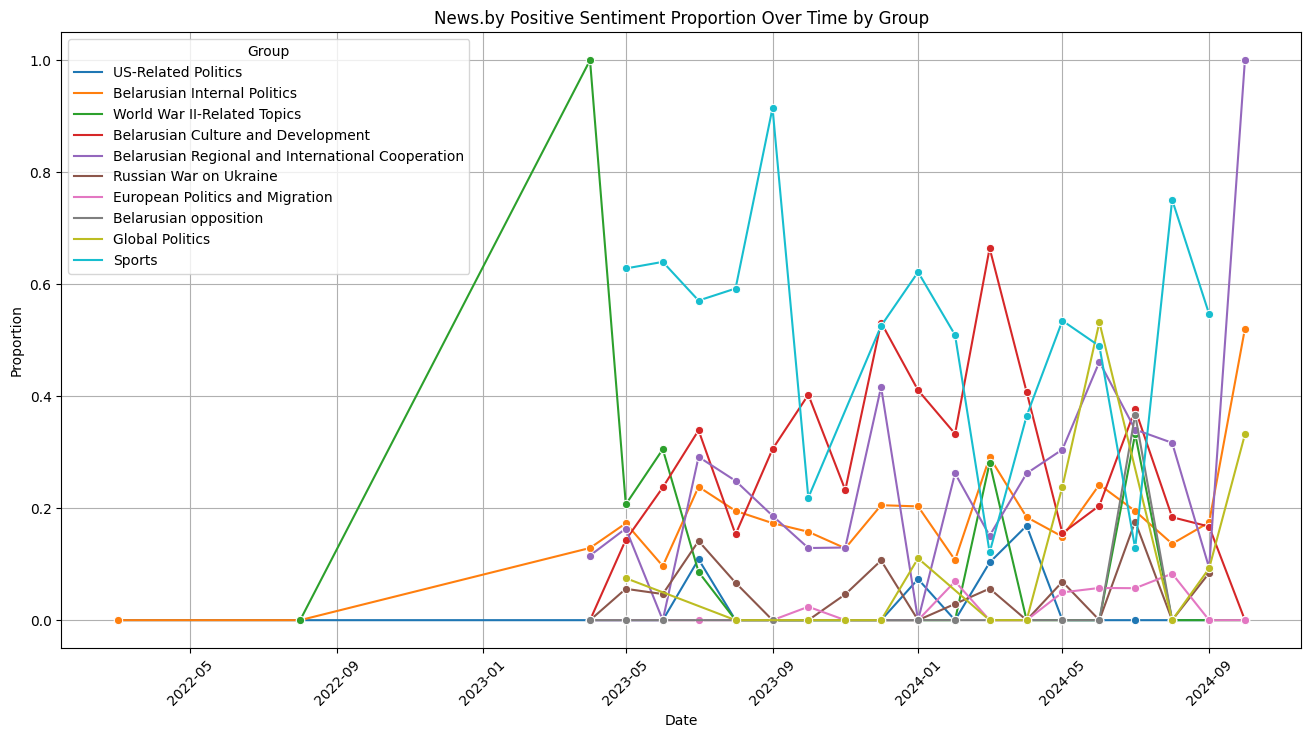

In [6]:
grouped_sentiment['Date'] = pd.to_datetime(grouped_sentiment['Date'])
grouped_sentiment = grouped_sentiment.sort_values('Date')

plt.figure(figsize=(16, 8))
sns.lineplot(data=grouped_sentiment, x='Date', y='Positive_Proportion', hue='Group', marker='o')
plt.title('News.by Positive Sentiment Proportion Over Time by Group')
plt.xlabel('Date')
plt.ylabel('Proportion')
plt.xticks(rotation=45, fontsize=10) 
plt.legend(title='Group')
plt.grid(True)
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


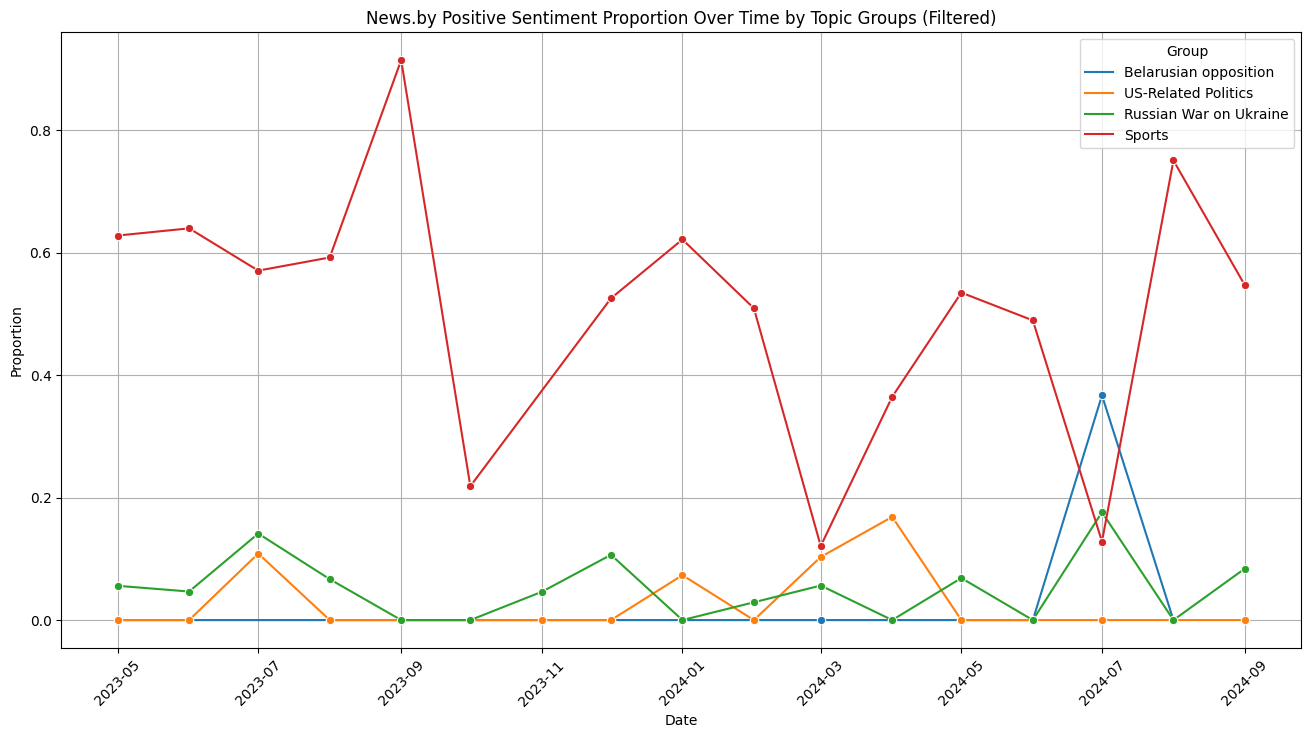

In [59]:
grouped_sentiment['Date'] = pd.to_datetime(grouped_sentiment['Date'])
grouped_sentiment = grouped_sentiment.sort_values('Date')

selected_groups = ["Russian War on Ukraine", "US-Related Politics", "Belarusian opposition", "Sports"]
filtered_data = grouped_sentiment[grouped_sentiment['Group'].isin(selected_groups)]

filtered_data = filtered_data[filtered_data['Positive_Proportion'] > 0]
min_date = filtered_data['Date'].min()

filtered_data = grouped_sentiment[(grouped_sentiment['Date'] >= min_date) & 
                                  (grouped_sentiment['Group'].isin(selected_groups))]

plt.figure(figsize=(16, 8))
sns.lineplot(data=filtered_data, x='Date', y='Positive_Proportion', hue='Group', marker='o')

plt.title('News.by Positive Sentiment Proportion Over Time by Topic Groups (Filtered)')
plt.xlabel('Date')
plt.ylabel('Proportion')
plt.xticks(rotation=45, fontsize=10) 
plt.legend(title='Group')
plt.grid(True)
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


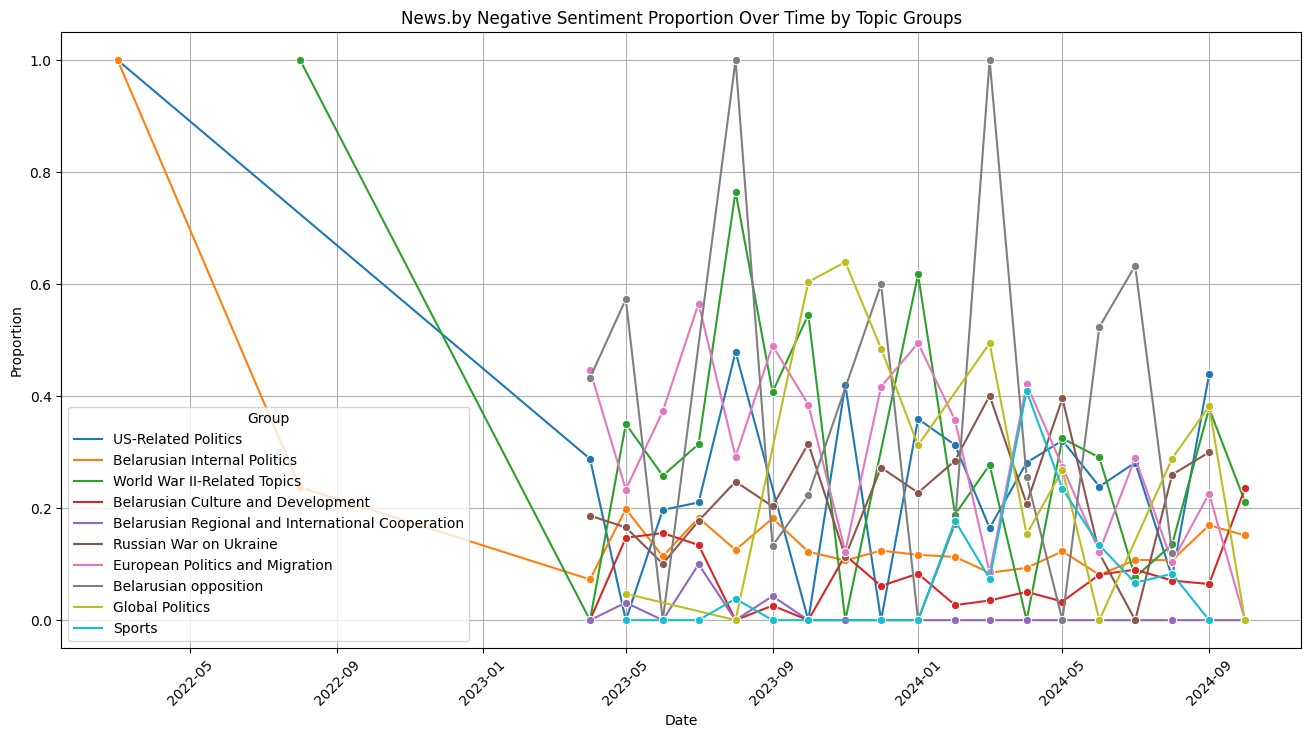

In [58]:
plt.figure(figsize=(16, 8))
sns.lineplot(data=grouped_sentiment, x='Date', y='Negative_Proportion', hue='Group', marker='o')
plt.title('News.by Negative Sentiment Proportion Over Time by Topic Groups')
plt.xlabel('Date')
plt.ylabel('Proportion')
plt.xticks(rotation=45, fontsize=10) 
plt.legend(title='Group')
plt.grid(True)
plt.show()

#### Fewer topics

In [127]:
topics = ["Russian War on Ukraine", "US-Related Politics", "Belarusian opposition", "Sports"]
new_sentiment = grouped_sentiment[~grouped_sentiment['Group'].isin(topics)]

In [133]:
new_sentiment.head()

,Group,Date,Positive_Score,Neutral_Score,Negative_Score,Total_Score,Positive_Proportion,Neutral_Proportion,Negative_Proportion,date_new
19,Belarusian Internal Politics,2022-03-01,0.000000,0.000000,0.657255,0.657255,0.0,0.000000,1.000000,2022-03-01
158,World War II-Related Topics,2022-08-01,0.000000,0.000000,0.541727,0.541727,0.0,0.000000,1.000000,2022-08-01
20,Belarusian Internal Politics,2022-08-01,0.000000,0.407947,0.126842,0.534789,0.0,0.762819,0.237181,2022-08-01
0,Belarusian Culture and Development,2023-04-01,0.000000,0.661134,0.000000,0.661134,0.0,1.000000,0.000000,2023-04-01
159,World War II-Related Topics,2023-04-01,0.766251,0.000000,0.000000,0.766251,1.0,0.000000,0.000000,2023-04-01


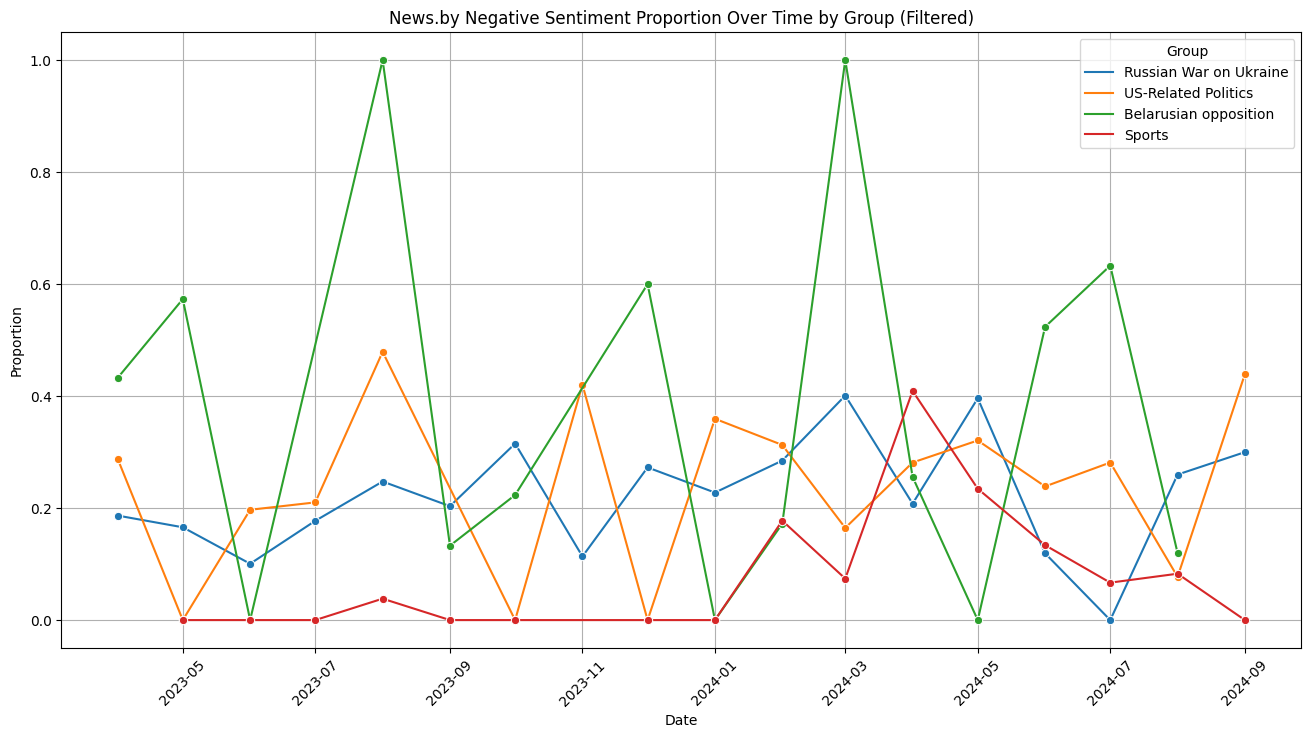

In [136]:
filtered_data = new_sentiment

filtered_data = filtered_data[filtered_data['Positive_Proportion'] > 0]
min_date = filtered_data['Date'].min()

filtered_data = grouped_sentiment[(grouped_sentiment['Date'] >= min_date) & 
                                  (grouped_sentiment['Group'].isin(selected_groups))]

plt.figure(figsize=(16, 8))
sns.lineplot(data=filtered_data, x='Date', y='Negative_Proportion', hue='Group', marker='o')

plt.title('News.by Negative Sentiment Proportion Over Time by Group (Filtered)')
plt.xlabel('Date')
plt.ylabel('Proportion')
plt.xticks(rotation=45, fontsize=10) 
plt.legend(title='Group')
plt.grid(True)
plt.show()

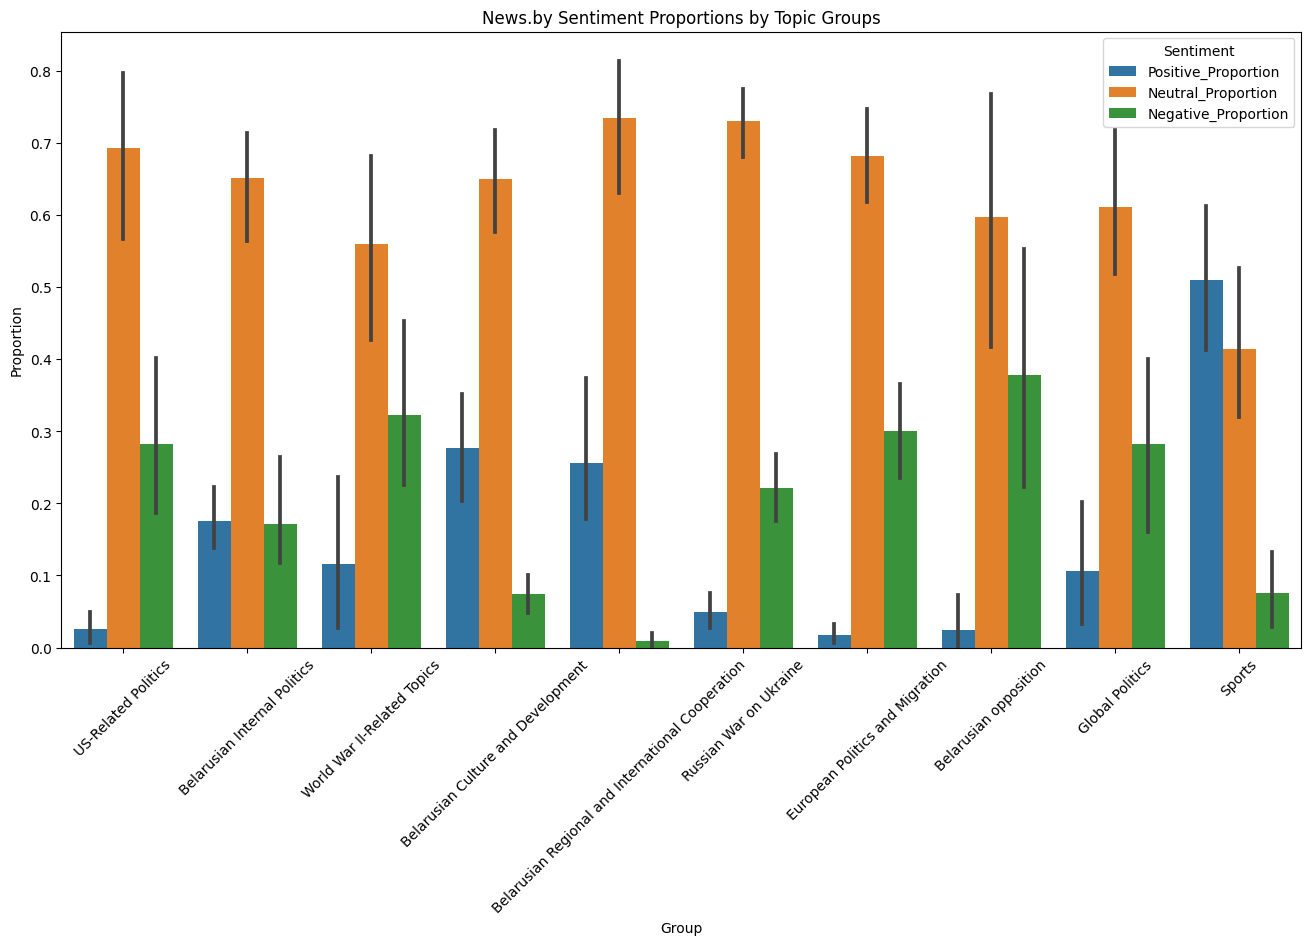

In [8]:
grouped_sentiment_long = grouped_sentiment.melt(
    id_vars=['Group'], 
    value_vars=['Positive_Proportion', 'Neutral_Proportion', 'Negative_Proportion'],
    var_name='Sentiment', 
    value_name='Proportion'
)
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(data=grouped_sentiment_long, x='Group', y='Proportion', ax=ax, hue='Sentiment')
plt.title('News.by Sentiment Proportions by Topic Groups')
plt.xlabel('Group')
plt.ylabel('Proportion')
plt.xticks(rotation=45, fontsize=10) 
plt.legend(title='Sentiment')
plt.show()

### Summary Table

In [11]:
selected_topics = ["Sports", "Russian War on Ukraine", "US-Related Politics", "Belarusian opposition"]
filtered_data = grouped_sentiment[grouped_sentiment['Group'].isin(selected_topics)]

# Computing the averages
sentiment_averages = filtered_data.groupby('Group')[
    ['Positive_Proportion','Negative_Proportion']
].mean().reset_index()

news_by_metrics = sentiment_averages

,Group,Positive_Proportion,Negative_Proportion
0,Belarusian opposition,0.024470,0.377723
1,Russian War on Ukraine,0.048772,0.221029
2,Sports,0.509743,0.076053
3,US-Related Politics,0.025205,0.281661


In [12]:
news_by_metrics = news_by_metrics.rename(columns={
    'Positive_Proportion': 'Positive Sentiment',
    'Negative_Proportion': 'Negative Sentiment'
})

In [14]:
news_by_metrics.to_csv('/Users/miraslavats/Library/CloudStorage/GoogleDrive-miraslava@uni.minerva.edu/My Drive/Capstone/bel_summary_table.csv')

## Emotion Analysis

In [38]:
exploded_data_for_modeling

,Unnamed: 0.1,Unnamed: 0,Date,Chunks,Processed_Chunks,Assigned_Topic_ID,Assigned_Topic_Name,Group,Final_Sentiment,Final_Sentiment_Score,Positive_Score,Neutral_Score,Negative_Score
0,0,0,2022-08-01,MUSICAL INTRO Belarus celebrates Independence ...,MUSICAL INTRO Belarus celebrates Independence ...,-1,Contemporary Belarusian State Affairs,Belarusian Internal Politics,Neutral_Score,0.468439,0.000000,0.468439,0.000000
1,1,1,2022-08-01,about their desires. They had a set goal of de...,desires. set goal destroying local Belarusian ...,-1,Contemporary Belarusian State Affairs,Belarusian Internal Politics,Neutral_Score,0.619217,0.000000,0.619217,0.000000
2,2,2,2022-08-01,hunt for her and her family. This is what a wo...,"hunt family. woman, seen life, says Nazism. un...",-1,Contemporary Belarusian State Affairs,Belarusian Internal Politics,Negative_Score,0.507367,0.000000,0.000000,0.507367
3,3,3,2022-08-01,my results from the criminal investigation est...,results criminal investigation established 198...,9,World War II Partisan Resistance,World War II-Related Topics,Negative_Score,0.541727,0.000000,0.000000,0.541727
4,4,4,2022-08-01,War. The memory of the Great Patriotic War is ...,War. memory Great Patriotic War safeguard Bela...,-1,Contemporary Belarusian State Affairs,Belarusian Internal Politics,Neutral_Score,0.544134,0.000000,0.544134,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4903,4903,4949,2024-09-01,discussing fewer problematic questions. Whethe...,discussing fewer problematic questions. likes ...,-1,Contemporary Belarusian State Affairs,Belarusian Internal Politics,Positive_Score,0.645135,0.645135,0.000000,0.000000
4904,4904,4950,2024-09-01,"Belarus, which should, in fact, create common ...","Belarus, should, fact, create common condition...",23,Military Security and Nuclear Threats,Belarusian Regional and International Cooperation,Neutral_Score,0.862583,0.000000,0.862583,0.000000
4905,4905,4951,2024-09-01,Threats to the union state and beyond were dis...,Threats union state discussed today response A...,-1,Contemporary Belarusian State Affairs,Belarusian Internal Politics,Neutral_Score,0.835978,0.000000,0.835978,0.000000
4906,4906,4952,2024-09-01,he had an arsenal of combat grenades. There ar...,arsenal combat grenades. episodes development ...,-1,Contemporary Belarusian State Affairs,Belarusian Internal Politics,Neutral_Score,0.675634,0.000000,0.675634,0.000000


In [31]:
from transformers import pipeline
from tqdm import tqdm
import pandas as pd

# Load the emotion classifier
classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True)

# Define a function to classify emotions and extract scores
def classify_emotions(text):
    try:
        results = classifier(text)
        scores = {result['label']: result['score'] for result in results[0]}
        return scores
    except Exception as e:
        print(f"Error processing text: {text[:50]}... - {e}")
        return {}

tqdm.pandas()
emotion_analysis_data['Emotion_Scores'] = emotion_analysis_data['Processed_Chunks'].progress_apply(classify_emotions)

# Splitting the Emotion_Scores into separate columns
emotion_columns = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
for emotion in emotion_columns:
    emotion_analysis_data[f'{emotion}_score'] = emotion_analysis_data['Emotion_Scores'].apply(lambda x: x.get(emotion, None))

emotion_analysis_data.drop(columns=['Emotion_Scores'], inplace=True)
print(emotion_analysis_data.head())

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
 94%|████████████████████████████████████▋  | 4613/4908 [06:00<00:20, 14.16it/s]

Error processing text: Editor subtitles A. Sinyetskaya Proofreader A. Kul... - The expanded size of the tensor (605) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 605].  Tensor sizes: [1, 514]


100%|███████████████████████████████████████| 4908/4908 [06:23<00:00, 12.80it/s]


         Date                                             Chunks  \
0  2022-08-01  MUSICAL INTRO Belarus celebrates Independence ...   
1  2022-08-01  about their desires. They had a set goal of de...   
2  2022-08-01  hunt for her and her family. This is what a wo...   
3  2022-08-01  my results from the criminal investigation est...   
4  2022-08-01  War. The memory of the Great Patriotic War is ...   

                                    Processed_Chunks  Assigned_Topic_ID  \
0  MUSICAL INTRO Belarus celebrates Independence ...                 -1   
1  desires. set goal destroying local Belarusian ...                 -1   
2  hunt family. woman, seen life, says Nazism. un...                 -1   
3  results criminal investigation established 198...                  9   
4  War. memory Great Patriotic War safeguard Bela...                 -1   

                     Assigned_Topic_Name                         Group  \
0  Contemporary Belarusian State Affairs  Belarusian Internal Poli

In [32]:
emotion_analysis_data['Final_Emotion'] = emotion_analysis_data[['anger_score', 'disgust_score', 'fear_score', 'joy_score', 'neutral_score', 'sadness_score', 'surprise_score']].idxmax(axis=1)
emotion_analysis_data['Final_Emotion_Score'] = emotion_analysis_data[['anger_score', 'disgust_score', 'fear_score', 'joy_score', 'neutral_score', 'sadness_score', 'surprise_score']].max(axis=1)

/var/folders/s5/nnqd5vlx3gxctyv9yyyny8j00000gn/T/ipykernel_68862/1450040514.py:1: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  emotion_analysis_data['Final_Emotion'] = emotion_analysis_data[['anger_score', 'disgust_score', 'fear_score', 'joy_score', 'neutral_score', 'sadness_score', 'surprise_score']].idxmax(axis=1)


In [33]:
# Remove the "_score" part from the values in the Final_Emotion column
emotion_analysis_data['Final_Emotion'] = emotion_analysis_data['Final_Emotion'].str.replace('_score', '', regex=False)
emotion_analysis_data.head()

,Date,Chunks,Processed_Chunks,Assigned_Topic_ID,Assigned_Topic_Name,Group,anger_score,disgust_score,fear_score,joy_score,neutral_score,sadness_score,surprise_score,Final_Emotion,Final_Emotion_Score
0,2022-08-01,MUSICAL INTRO Belarus celebrates Independence ...,MUSICAL INTRO Belarus celebrates Independence ...,-1,Contemporary Belarusian State Affairs,Belarusian Internal Politics,0.014040,0.003067,0.001671,0.014465,0.014898,0.945653,0.006206,sadness,0.945653
1,2022-08-01,about their desires. They had a set goal of de...,desires. set goal destroying local Belarusian ...,-1,Contemporary Belarusian State Affairs,Belarusian Internal Politics,0.117490,0.001567,0.846948,0.007102,0.003796,0.020087,0.003010,fear,0.846948
2,2022-08-01,hunt for her and her family. This is what a wo...,"hunt family. woman, seen life, says Nazism. un...",-1,Contemporary Belarusian State Affairs,Belarusian Internal Politics,0.017840,0.003712,0.952985,0.001618,0.002042,0.004520,0.017282,fear,0.952985
3,2022-08-01,my results from the criminal investigation est...,results criminal investigation established 198...,9,World War II Partisan Resistance,World War II-Related Topics,0.001581,0.001107,0.003238,0.001600,0.004068,0.984571,0.003834,sadness,0.984571
4,2022-08-01,War. The memory of the Great Patriotic War is ...,War. memory Great Patriotic War safeguard Bela...,-1,Contemporary Belarusian State Affairs,Belarusian Internal Politics,0.004337,0.001398,0.955250,0.018391,0.006030,0.012932,0.001662,fear,0.955250


In [61]:
emotion_analysis_data["Group"].unique()

array(['Belarusian Internal Politics', 'World War II-Related Topics',
       'US-Related Politics', 'Belarusian Culture and Development',
       'Russian War on Ukraine', 'European Politics and Migration',
       'Belarusian opposition',
       'Belarusian Regional and International Cooperation',
       'Global Politics', 'Sports'], dtype=object)

In [62]:
emotion_analysis_data.to_csv("/Users/miraslavats/Library/CloudStorage/GoogleDrive-miraslava@uni.minerva.edu/My Drive/Capstone/bel_sentiment_emotion/emotion_dataset.csv")

In [40]:
# Grouping by time and topic
grouped_emotion = emotion_analysis_data.groupby(['Group', 'Date'])[['anger_score', 'disgust_score', 'fear_score', 'joy_score', 'neutral_score', 'sadness_score', 'surprise_score']].mean().reset_index()

In [41]:
grouped_emotion['Total_Score'] = grouped_emotion[['anger_score', 'disgust_score', 'fear_score', 'joy_score', 'neutral_score', 'sadness_score', 'surprise_score']].sum(axis=1)
grouped_emotion['anger_Proportion'] = grouped_emotion['anger_score'] / grouped_emotion['Total_Score']
grouped_emotion['disgust_Proportion'] = grouped_emotion['disgust_score'] / grouped_emotion['Total_Score']
grouped_emotion['fear_Proportion'] = grouped_emotion['fear_score'] / grouped_emotion['Total_Score']
grouped_emotion['joy_Proportion'] = grouped_emotion['joy_score'] / grouped_emotion['Total_Score']
grouped_emotion['neutral_Proportion'] = grouped_emotion['neutral_score'] / grouped_emotion['Total_Score']
grouped_emotion['sadness_Proportion'] = grouped_emotion['sadness_score'] / grouped_emotion['Total_Score']
grouped_emotion['surprise_Proportion'] = grouped_emotion['surprise_score'] / grouped_emotion['Total_Score']

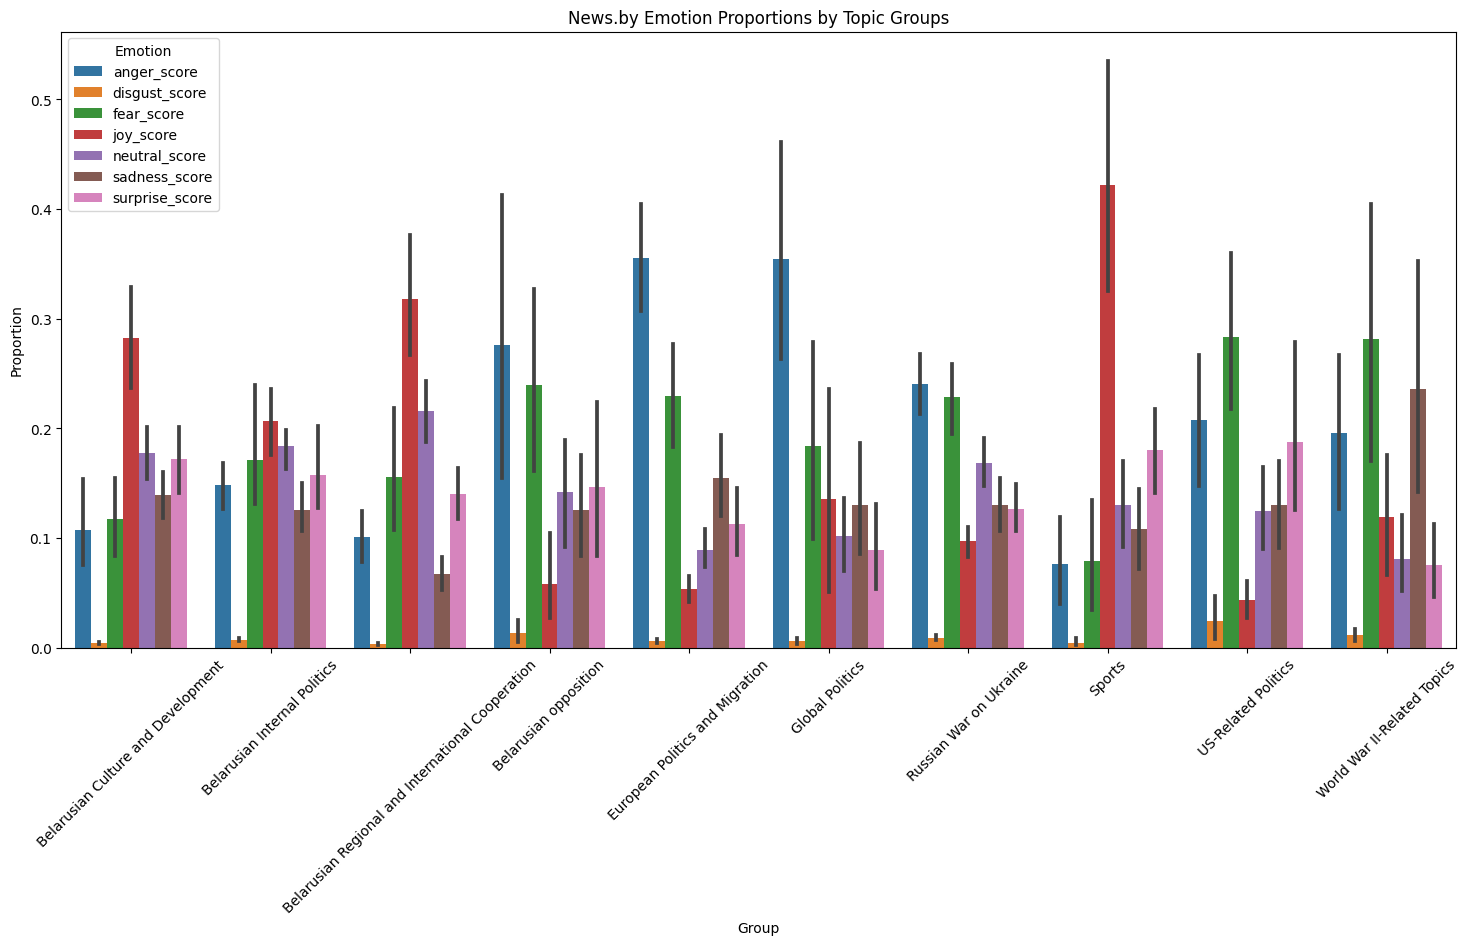

In [42]:
grouped_emotion_long = grouped_emotion.melt(
    id_vars=['Group'], 
    value_vars=['anger_score', 'disgust_score', 'fear_score', 'joy_score', 
                'neutral_score', 'sadness_score', 'surprise_score'],
    var_name='Emotion', 
    value_name='Proportion'
)
fig, ax = plt.subplots(figsize=(18, 8))
sns.barplot(data=grouped_emotion_long, x='Group', y='Proportion', ax=ax, hue='Emotion')
plt.title('News.by Emotion Proportions by Topic Groups')
plt.xlabel('Group')
plt.ylabel('Proportion')
plt.xticks(rotation=45, fontsize=10) 
plt.legend(title='Emotion')
plt.show()

In [43]:
date_mapping = {
    "April 2023.0": "2023-04-01",
    "April 2024.0": "2024-04-01",
    "September 2023.0": "2023-09-01",
    "October 2023.0": "2023-10-01",
    "October 2024.0": "2024-10-01",
    "November 2023.0": "2023-11-01",
    "May 2024.0": "2024-05-01",
    "May 2023.0": "2023-05-01",
    "March 2024.0": "2024-03-01",
    "March 2022.0": "2022-03-01",
    "June 2024.0": "2024-06-01",
    "June 2023.0": "2023-06-01",
    "July 2024.0": "2024-07-01",
    "July 2023.0": "2023-07-01",
    "January 2024.0": "2024-01-01",
    "February 2024.0": "2024-02-01",
    "December 2023.0": "2023-12-01",
    "August 2024.0": "2024-08-01",
    "August 2023.0": "2023-08-01",
    "August 2022.0": "2022-08-01",
    "September 2024.0": "2024-09-01"
}
# Map the dates using the dictionary
grouped_emotion['date_new'] = grouped_emotion['Date'].map(date_mapping)

# Convert to pandas datetime format for plotting
grouped_emotion['date_new'] = pd.to_datetime(grouped_emotion['date_new'])

In [44]:
grouped_emotion['Group'].unique()

array(['Belarusian Culture and Development',
       'Belarusian Internal Politics',
       'Belarusian Regional and International Cooperation',
       'Belarusian opposition', 'European Politics and Migration',
       'Global Politics', 'Russian War on Ukraine', 'Sports',
       'US-Related Politics', 'World War II-Related Topics'], dtype=object)

In [45]:
topics = ['Sports', 
          'Russian War on Ukraine', 
          'US-Related Politics',
          'Belarusian opposition']

new_emotion = grouped_emotion[grouped_emotion['Group'].isin(topics)]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_ol

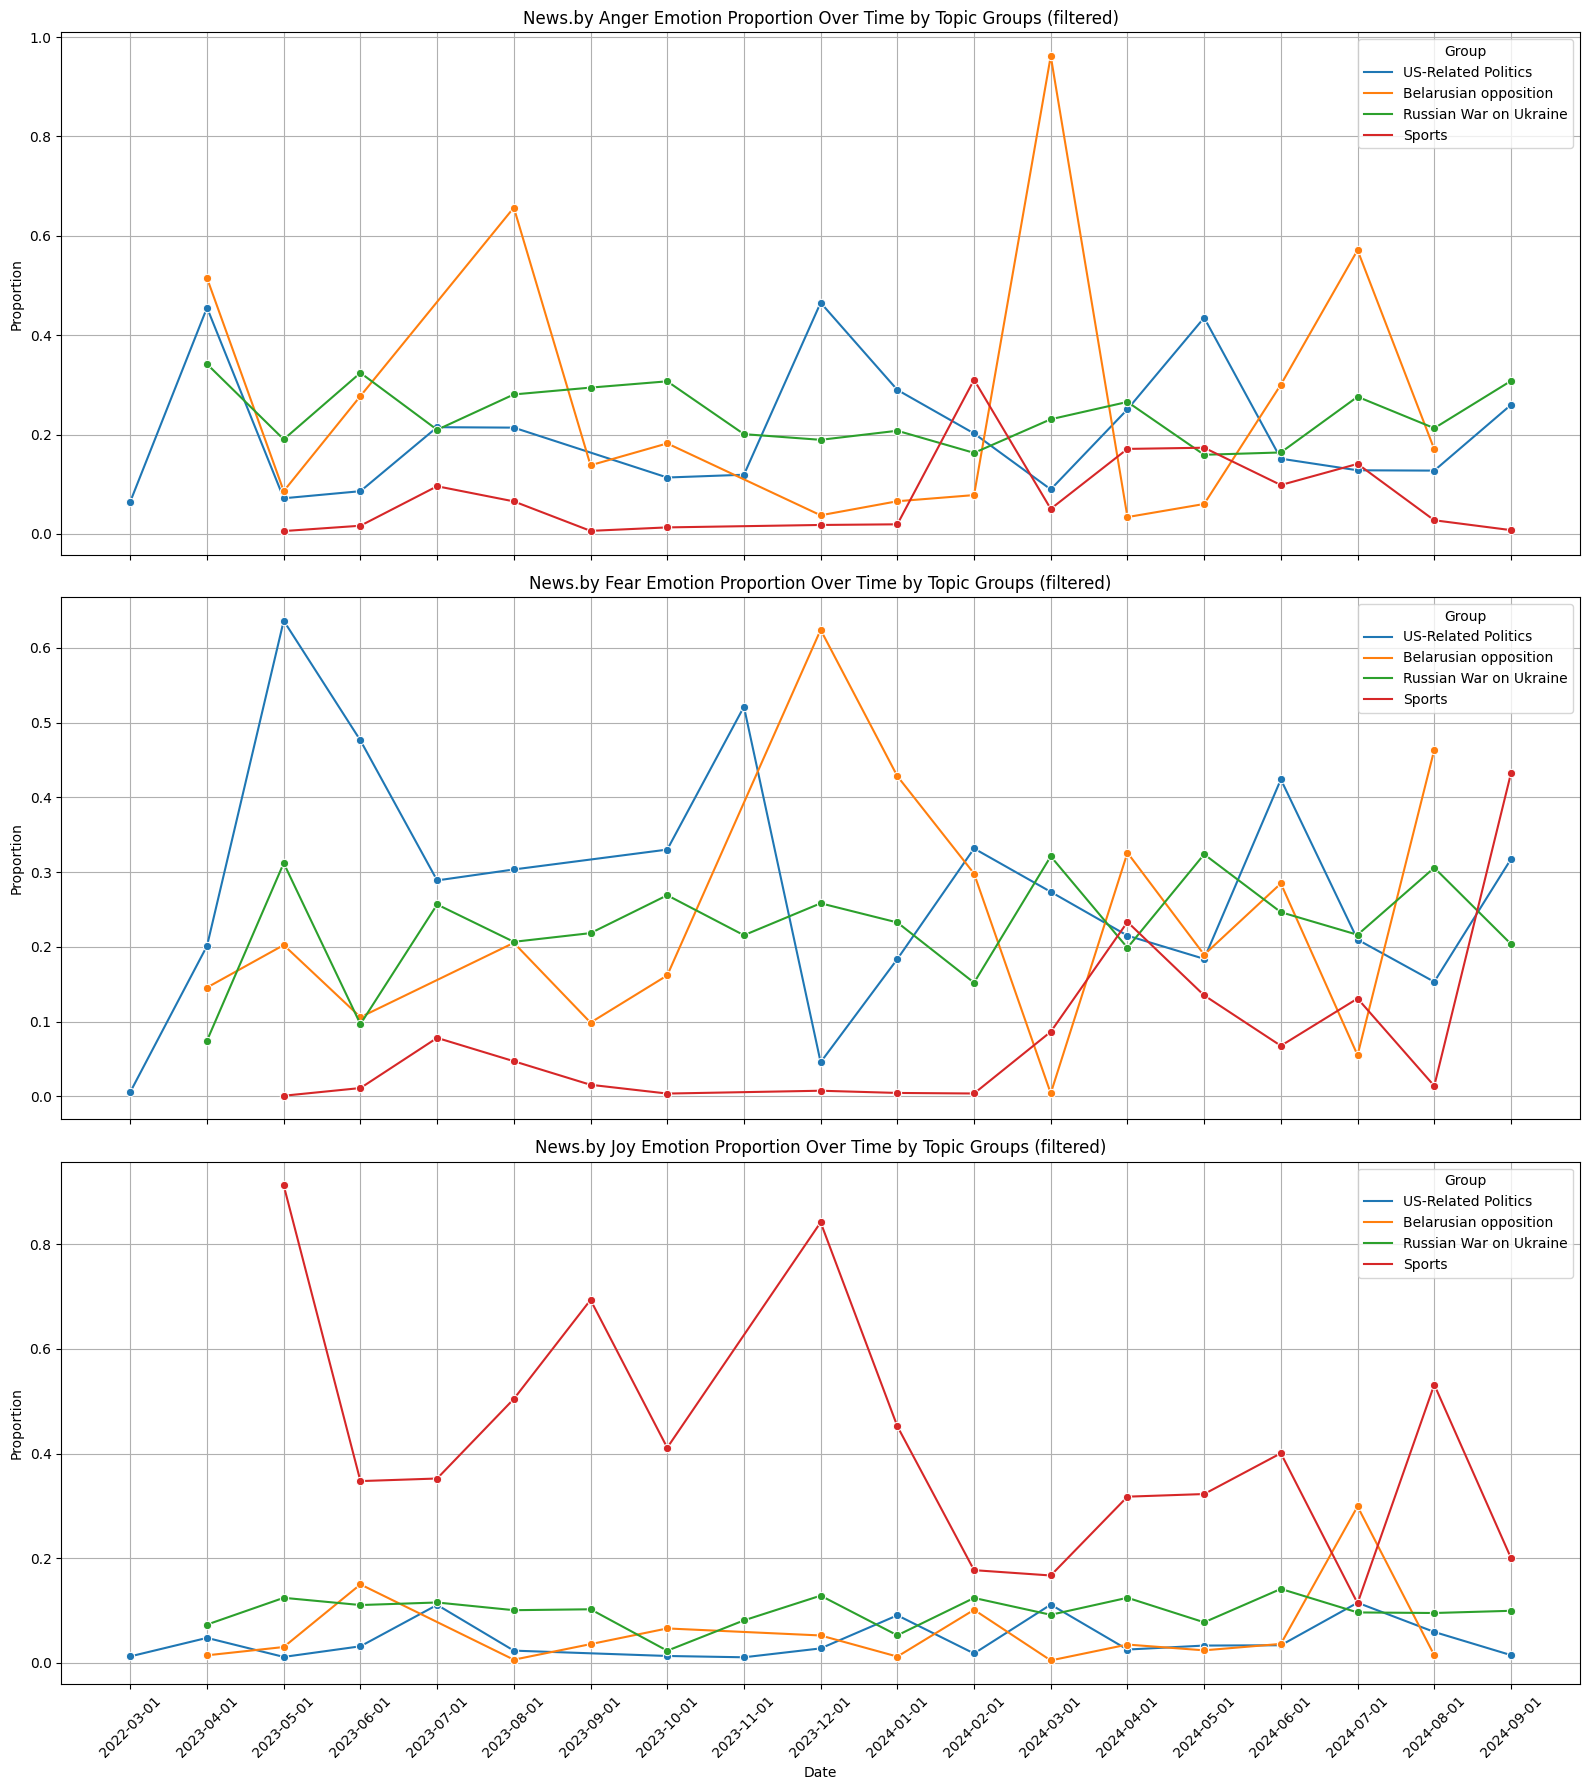

In [53]:
new_emotion = new_emotion.sort_values('Date')
fig, axes = plt.subplots(3, 1, figsize=(16, 18), sharex=True)


# Define the emotions and titles
emotions = ['anger_score', 'fear_score', 'joy_score']
titles = ['Anger Emotion Proportion Over Time', 
          'Fear Emotion Proportion Over Time', 
          'Joy Emotion Proportion Over Time']

for i, (emotion, title) in enumerate(zip(emotions, titles)):
    sns.lineplot(data=new_emotion, x='Date', y=emotion, hue='Group', marker='o', ax=axes[i])
    axes[i].set_title(f'News.by {title} by Topic Groups (filtered)')
    axes[i].set_ylabel('Proportion')
    axes[i].legend(title='Group')
    axes[i].grid(True)

    axes[-1].set_xlabel('Date')
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.savefig("news_by_emotions_over_time.png", dpi=300, bbox_inches='tight')
plt.show()

In [55]:
selected_topics = ["Sports", "Russian War on Ukraine", "US-Related Politics", "Belarusian opposition"]
filtered_emotion = new_emotion[new_emotion['Group'].isin(selected_topics)]

emotion_averages = filtered_emotion.groupby('Group')[
    ['fear_score', 'anger_score', 'joy_score']
].mean().reset_index()

emotion_averages = emotion_averages.rename(columns={
    'fear_score': 'Fear Proportion',
    'anger_score': 'Anger Proportion',
    'joy_score': 'Joy Proportion'
})

news_by_metrics = news_by_metrics.merge(emotion_averages, on='Group', how='left')

                    Group  Positive Sentiment  Negative Sentiment  \
0   Belarusian opposition            0.024470            0.377723   
1  Russian War on Ukraine            0.048772            0.221029   
2                  Sports            0.509743            0.076053   
3     US-Related Politics            0.025205            0.281661   

   Fear Proportion  Anger Proportion  Joy Proportion  
0         0.239465          0.275733        0.058388  
1         0.228157          0.240385        0.097568  
2         0.079350          0.076335        0.421584  
3         0.283319          0.207800        0.043499  


In [57]:
news_by_metrics.to_csv('/Users/miraslavats/Library/CloudStorage/GoogleDrive-miraslava@uni.minerva.edu/My Drive/Capstone/bel_summary_table.csv')